## 0. Goal
Re-run UMAP on all renditions of the same syllables, including data from first sort batch and second supplementary sort <br>
Differ from v1: not saving the large meta info about every sliding window, save information at the syllable level instead. 

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import os, sys, importlib, librosa, glob, h5py, tqdm, pickle, gc, shutil
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter, OrderedDict
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from skimage import transform
import gc

plt.rcParams['pdf.fonttype'] = 42 

In [3]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)

<module 'vae_goffinet' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/vae_goffinet.py'>

In [4]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [5]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
birdID = 'pair5RigCCU29'
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clim = [1.5,7]
# where are data located
fd_save_base = os.path.join(fd_data, birdID, 'Traj', 'applySylAll')
# what latents to use
vae_run = 'traj_chop_32_1_32'
fd_latent = os.path.join(fd_save_base, f'latents.{vae_run}')
fn_latent = os.path.join(fd_latent, f'{birdID}.latents.{vae_run}.h5')
fn_latent_info = os.path.join(fd_latent, f'{birdID}.latents.{vae_run}.info.csv')
info = pd.read_csv(fn_latent_info, index_col=0)
print(info.shape)
# how large is sliding window
win_frame = 32
# what VAE model to use
vae_run = 'traj_chop_32_1_32'
fd_vae = '/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/VAE5/traj_chop_32_1_32/'
fn_vae = os.path.join(fd_vae, f'{birdID}_checkpoint_final.tar')

(92140, 24)


In [6]:
# define parameters for spectrograms
X_SHAPE = [128, 128]
p = {
    'get_spec': vae_goffinet.get_specZZ, # spectrogram maker
    'max_dur': 1e9, # maximum syllable duration
    'min_freq': 250, # minimum frequency
    'max_freq': 7500, # maximum frequency, default 7500
    'num_freq_bins': X_SHAPE[0], # hard-coded
    'num_time_bins': X_SHAPE[1], # hard-coded
    'nperseg': 256, # FFT
    'noverlap': 236, # FFT, determines window overlap when calculating spectrograms
    'spec_min_val': clim[0], # minimum log-spectrogram value
    'spec_max_val': clim[1], # maximum log-spectrogram value
    'fs': 20000, # audio samplerate
    'mel': False, # frequency spacing, mel or linear
    'time_stretch': False, # stretch short syllables?
    'within_syll_normalize': False, # normalize spectrogram values on a # spectrogram-by-spectrogram basis
    'pad': 0.08,  # when extracting syllables for calculating spectrograms, pad before syllable onset and after syllable onset, unit is sec
    'win_frame': win_frame,  # duration of the sliding window, unit is spectrogram column
    'hop_frame': 1, # how much to slide for consecutive window, unit is spectrogram column
    'win_pad': win_frame, # how much to include before syllable onset, unit is spectrogram column, default to one sliding window
}

In [7]:
# parameters for UMAP
param_umap = {'n_components':2, 'n_neighbors':25, 'min_dist':0, 'metric':'euclidean'}

## 2. Run UMAP with different selected syllables

### Compile the data and meta info

In [8]:
# # what syllables to select: paired v4/v5 only
# umap_run = 'umapAll.v4v5'
# syl = ['v4', 'v5']
# batch = ['batch1', 'batch2']

In [9]:
# # what syllables to select: paired v1/v7 only
# umap_run = 'umapAll.v1v7'
# syl = ['v1', 'v7']
# batch = ['batch1', 'batch2']

In [8]:
# what syllables to select: paired v1/v7 only
syl = [f'v{ii}' for ii in range(1,8)]
syl_str = ''.join(syl)
umap_run = f'umapAll.{syl_str}'
print(syl)
batch = ['batch1', 'batch2']

['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7']


In [9]:
fd_umap = os.path.join(fd_save_base, umap_run)
if not os.path.exists(fd_umap):
    os.makedirs(fd_umap)
print('Saving UMAP results to: ', fd_umap)

Saving UMAP results to:  /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/applySylAll/umapAll.v1v2v3v4v5v6v7


In [10]:
# select syllables
info_s = info[info['call_subtype'].isin(syl) & info['batch'].isin(batch)].copy()
print(info_s.shape)
print(Counter(info_s['batch']))

(22954, 24)
Counter({'batch1': 20952, 'batch2': 2002})


In [11]:
# read in all the VAE data, construct meta info at the syllable level
info_umap = []
d_latents = []
count = 0
with h5py.File(fn_latent, "r") as f:
    for ri in tqdm.tqdm(info_s.index):
    # for ri in info_s.index[0:3]:
        syl_ID = info_s.loc[ri, 'syl_ID']
        d = f[syl_ID][:]
        # exclude the extra silent pad
        d_latents.append(d)
        # grab info regarding the syllable
        row = info[info['syl_ID']==syl_ID].copy()
        row.index = range(row.shape[0])
        row.loc[0, 'count_start'] = count
        count = count + d.shape[0]
        row.loc[0, 'count_end'] = count
        info_umap.append(row)

100%|██████████| 22954/22954 [02:26<00:00, 156.21it/s]


In [12]:
# convert to dataframe
info_umap = pd.concat(info_umap, ignore_index=True)
info_umap['count_start'] = info_umap['count_start'].astype('int64')
info_umap['count_end'] = info_umap['count_end'].astype('int64')
info_umap.shape

(22954, 26)

In [13]:
# convert latents to np array
d = np.vstack(d_latents)
d.shape

(4535708, 32)

In [14]:
info_umap.loc[info_umap.shape[0]-1, 'count_end']

4535708

In [15]:
del d_latents
gc.collect()

0

### Run UMAP

In [16]:
print(param_umap)
umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                              metric=param_umap['metric'], random_state=1118, verbose=True)
res = umap_model.fit_transform(d)

{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'euclidean'}
UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Tue Aug  5 23:31:39 2025 Construct fuzzy simplicial set
Tue Aug  5 23:31:40 2025 Finding Nearest Neighbors
Tue Aug  5 23:31:40 2025 Building RP forest with 64 trees
Tue Aug  5 23:33:27 2025 NN descent for 22 iterations
	 1  /  22
	 2  /  22
	Stopping threshold met -- exiting after 2 iterations
Tue Aug  5 23:37:45 2025 Finished Nearest Neighbor Search
Tue Aug  5 23:38:15 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Aug  6 00:38:04 2025 Finished embedding


In [17]:
res.shape

(4535708, 2)

In [18]:
# save the embedding
fn_embed = os.path.join(fd_umap, f'{birdID}.{umap_run}.embedding.csv')
np.savetxt(fn_embed, res, delimiter=',')
print(fn_embed)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/applySylAll/umapAll.v1v2v3v4v5v6v7/pair5RigCCU29.umapAll.v1v2v3v4v5v6v7.embedding.csv


In [19]:
# save the meta info
fn_info = os.path.join(fd_umap, f'{birdID}.{umap_run}.info.csv')
info_umap.to_csv(fn_info)

In [20]:
# save the UMAP model for later usage
fn_umap = os.path.join(fd_umap, f'UMAPmodel.{birdID}.{umap_run}.p')
pickle.dump(umap_model, open(fn_umap, 'wb'))

Wed Aug  6 00:43:56 2025 Worst tree score: 0.79458664
Wed Aug  6 00:43:56 2025 Mean tree score: 0.79592306
Wed Aug  6 00:43:56 2025 Best tree score: 0.79725370
Wed Aug  6 00:44:17 2025 Forward diversification reduced edges from 113392700 to 31108174
Wed Aug  6 00:44:22 2025 Reverse diversification reduced edges from 31108174 to 31108172
Wed Aug  6 00:44:26 2025 Degree pruning reduced edges from 34154270 to 34154270
Wed Aug  6 00:44:26 2025 Resorting data and graph based on tree order
Wed Aug  6 00:44:28 2025 Building and compiling search function


### Plot trajectories to check (optional)

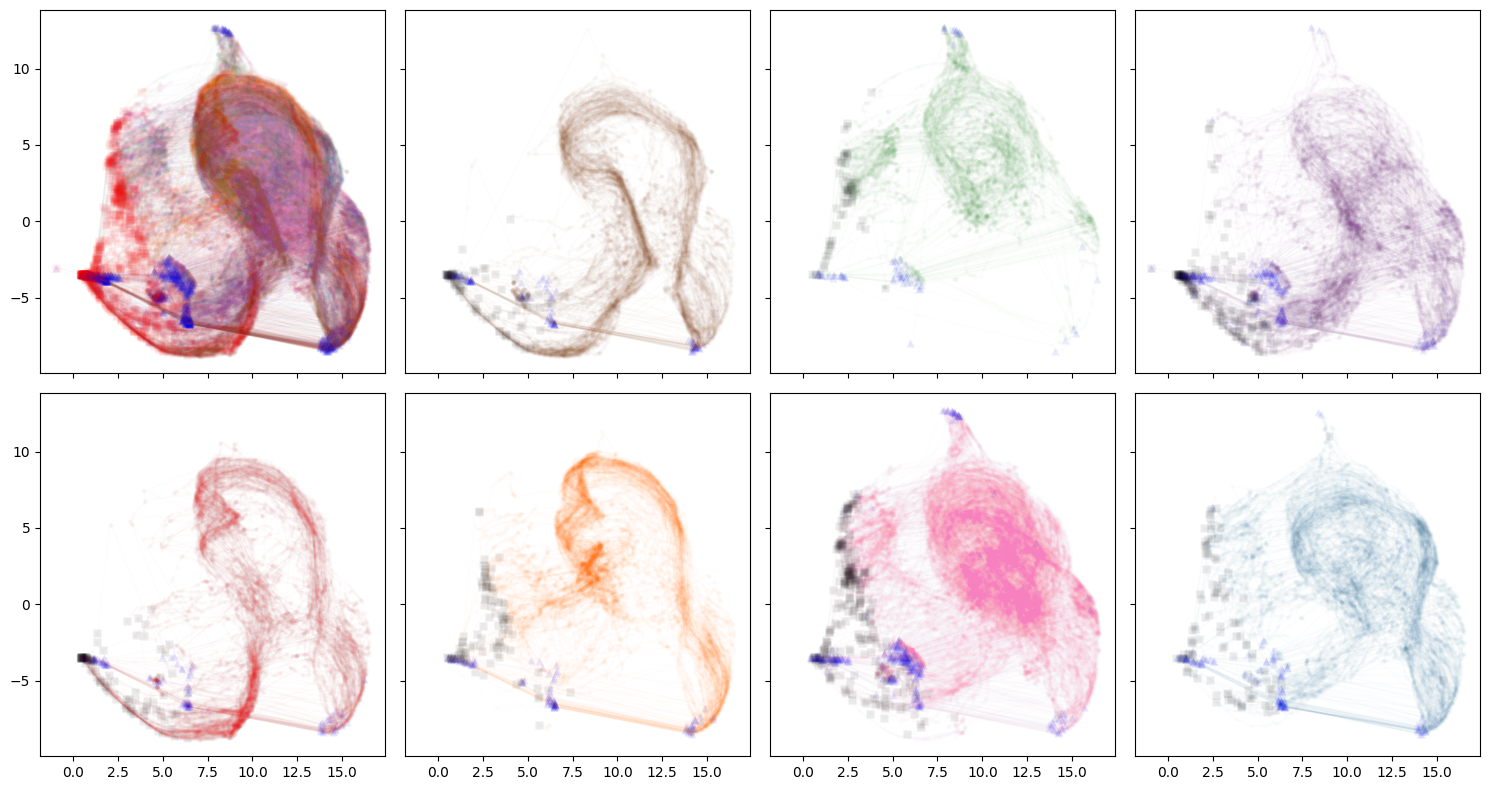

In [30]:
#### plot results, different color for different call subtypes
col_full = ['#a65628','#4daf4a','#984ea3','#e41a1c','#ff7f00','#f781bf','#377eb8','#737373']
col_dict = OrderedDict(zip(syl, col_full[0:len(syl)]))
# get the syl id
syl_comb = sorted(list(set(info_s['syl_ID'])))
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[15, 5.5], sharex=True, sharey=True)
# fig, axes = plt.subplots(nrows=2, ncols=4, figsize=[15, 8], sharex=True, sharey=True)
syl_counts = np.zeros([len(syl),1])
# for si in range(len(syl_comb)):
for si in range(1000):
    ss = syl_comb[si]
    # locate the start and end in the res
    temp = info_umap.loc[info_umap['syl_ID']==ss, :]
    i_start = temp['count_start'].item()
    i_end = temp['count_end'].item()
    x = res[i_start:i_end, 0]
    y = res[i_start:i_end, 1]
    v = temp['call_subtype'].item()
    vi = syl.index(v)
    # first  plot in overlaid
    ax = axes[0]
    ax.plot(x, y,  marker='o', linestyle='-', color=col_dict[v], markersize=3, linewidth=1, alpha=0.015, rasterized=True, markeredgecolor='none')
    # mark the start with triangle, and end with square
    ax.plot(x[0], y[0], marker='^', markersize=6, color='blue', alpha=0.075, rasterized=True, markeredgecolor='none')
    ax.plot(x[-1], y[-1], marker='s', markersize=6, color='red', alpha=0.075, rasterized=True, markeredgecolor='none')
    # then plot in separate
    ax = axes[vi+1]
    syl_counts[vi] += 1
    ax.plot(x, y,  marker='o', linestyle='-', color=col_dict[v], markersize=3, linewidth=1, alpha=0.015, rasterized=True, markeredgecolor='none')
    # mark the start with triangle, and end with square
    ax.plot(x[0], y[0], marker='^', markersize=6, color='blue', alpha=0.075, rasterized=True, markeredgecolor='none')
    ax.plot(x[-1], y[-1], marker='s', markersize=6, color='black', alpha=0.075, rasterized=True, markeredgecolor='none')
# add legend
legends = [Patch(facecolor=col_dict[name], label=name) for name in col_dict.keys()]
ax = axes[0]
ax.legend(handles=legends, loc='lower right', fontsize=12)
add xy axis labels
for ai in range(len(axes)):
    ax = axes[ai]
    if ai>0:
        ax.set_title(f'{birdID}: {umap_run} n={syl_counts[ai-1]}', fontsize=10)
    else:
        ax.set_title(f'{birdID}: {umap_run}', fontsize=10)
    ax.set_xlabel('UMAP axis 1', fontsize=12)
    ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()

# save fig
# fn_fig = os.path.join(fd_umap, f'{birdID}.{umap_run}.embedding.pdf')
# fig.savefig(fn_fig, dpi=600)

In [ ]:
#### plot results, different color for different call subtypes
col_full = ['#a65628','#4daf4a','#984ea3','#e41a1c','#ff7f00','#f781bf','#377eb8','#737373']
col_dict = OrderedDict(zip(syl, col_full[0:len(syl)]))
# get the syl id
syl_comb = sorted(list(set(info_s['syl_ID'])))
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[15, 5.5], sharex=True, sharey=True)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=[15, 8], sharex=True, sharey=True)
syl_counts = np.zeros([len(syl),1])
for si in range(len(syl_comb)):
# for si in range(100):
    ss = syl_comb[si]
    # locate the start and end in the res
    temp = info_umap.loc[info_umap['syl_ID']==ss, :]
    i_start = temp['count_start'].item()
    i_end = temp['count_end'].item()
    x = res[i_start:i_end, 0]
    y = res[i_start:i_end, 1]
    v = temp['call_subtype'].item()
    vi = syl.index(v)
    # first  plot in overlaid
    ax = axes[0][0]
    ax.plot(x, y,  marker='o', linestyle='-', color=col_dict[v], markersize=3, linewidth=1, alpha=0.015, rasterized=True, markeredgecolor='none')
    # mark the start with triangle, and end with square
    ax.plot(x[0], y[0], marker='^', markersize=6, color='blue', alpha=0.075, rasterized=True, markeredgecolor='none')
    ax.plot(x[-1], y[-1], marker='s', markersize=6, color='red', alpha=0.075, rasterized=True, markeredgecolor='none')
    # then plot in separate
    plot_i = (vi+1)//4
    plot_j = (vi+1)%4
    ax = axes[plot_i][plot_j]
    # ax = axes[vi+1]
    syl_counts[vi] += 1
    ax.plot(x, y,  marker='o', linestyle='-', color=col_dict[v], markersize=3, linewidth=1, alpha=0.015, rasterized=True, markeredgecolor='none')
    # mark the start with triangle, and end with square
    ax.plot(x[0], y[0], marker='^', markersize=6, color='blue', alpha=0.075, rasterized=True, markeredgecolor='none')
    ax.plot(x[-1], y[-1], marker='s', markersize=6, color='black', alpha=0.075, rasterized=True, markeredgecolor='none')
# add legend
legends = [Patch(facecolor=col_dict[name], label=name) for name in col_dict.keys()]
ax = axes[0][0]
ax.legend(handles=legends, loc='lower right', fontsize=12)
# add xy axis labels
for plot_i in range(2):
    for plot_j in range(4):
        ax = axes[plot_i][plot_j]
        vi = plot_i*4+plot_j-1
        if plot_i==0 and plot_j==0:
            ax.set_title(f'{birdID}: {umap_run}', fontsize=10)
        else:
            ax.set_title(f'{birdID}: {syl[vi]} n={syl_counts[vi]}', fontsize=10)
        ax.set_xlabel('UMAP axis 1', fontsize=12)
        ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()

#save fig
fn_fig = os.path.join(fd_umap, f'{birdID}.{umap_run}.embedding.pdf')
fig.savefig(fn_fig, dpi=600)